<a href="https://colab.research.google.com/github/greengerong/awesome-llm/blob/main/colab/autogen/autogen_kimi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 环境安装

In [1]:
!mkdir autogen
%cd /content/autogen
!touch OAI_CONFIG_LIST
!pip install pyautogen
!pip install -qqq matplotlib numpy
!pip install --upgrade 'openai>=1.0'

/content/autogen
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.5/244.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00


# moonshot

In [6]:
from openai import OpenAI
from autogen import config_list_from_json

config_list = config_list_from_json(env_or_file="OAI_CONFIG_LIST")

client = OpenAI(
    api_key=config_list[0]['api_key'],
    base_url=config_list[0]['base_url'],
)

history = [
    {"role": "system", "content": "你是 Kimi，由 Moonshot AI 提供的人工智能助手，你更擅长中文和英文的对话。你会为用户提供安全，有帮助，准确的回答。同时，你会拒绝一切涉及恐怖主义，种族歧视，黄色暴力等问题的回答。Moonshot AI 为专有名词，不可翻译成其他语言。"}
]

def chat(query, history):
    history += [{
        "role": "user",
        "content": query
    }]
    completion = client.chat.completions.create(
        model="moonshot-v1-8k",
        messages=history,
        temperature=0.3,
    )
    result = completion.choices[0].message.content
    history += [{
        "role": "assistant",
        "content": result
    }]
    return result

print(chat("地球的自转周期是多少？", history))
print(chat("月球呢？", history))

地球的自转周期，也就是地球绕着自己的轴线旋转一周所需的时间，通常被称为一天。这个周期大约是24小时。不过，由于地球在自转的同时还在绕太阳公转，以及受到月球引力的影响，实际上地球的自转周期有极微小的变化。例如，地球的自转速度会因为地球内部质量分布的变化、潮汐摩擦等因素而发生极其微小的改变。但是，为了日常生活的方便，我们通常将一天定义为24小时。
月球的自转周期与它的公转周期相同，这个现象称为潮汐锁定。这意味着月球绕地球转一圈的时间和它自己旋转一圈的时间是一样的，大约是27.3天（更精确地说是27天7小时43分11.5秒）。因此，月球总是有一面朝向地球，这一面被称为近地面，而另一面则是远地面。

由于这种同步的自转和公转，地球上的观察者只能从地球上看到月球的一面，这也是为什么有时被称为“月球的暗面”的原因，尽管这个称呼有些误导，因为月球的远地面也会受到阳光照射，只是从地球上看不到而已。


# autogen

In [13]:
import autogen
import datetime
import os
from autogen import AssistantAgent, UserProxyAgent,config_list_from_json,ConversableAgent
import tempfile
from autogen.coding import DockerCommandLineCodeExecutor,LocalCommandLineCodeExecutor
from IPython.display import Image

config_list = config_list_from_json(env_or_file="OAI_CONFIG_LIST")
llm_config={"config_list": config_list}

# Create a temporary directory to store the code files.
temp_dir = tempfile.TemporaryDirectory()

# Create a local command line code executor.
executor = LocalCommandLineCodeExecutor(
    timeout=10,  # Timeout for each code execution in seconds.
    work_dir=temp_dir.name,  # Use the temporary directory to store the code files.
)

# Create an agent with code executor configuration.
code_executor_agent = ConversableAgent(
    "code_executor_agent",
    system_message="Reply 'TERMINATE' in the end when code execute success.",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": executor},  # Use the local command line code executor.
    human_input_mode="NEVER",  # ALWAYS: Always take human input for this agent for safety.
    is_termination_msg=lambda msg: msg.get("content") is not None and "Great!" in msg["content"],
)


# The code writer agent's system message is to instruct the LLM on how to use
# the code executor in the code executor agent.
code_writer_system_message = """You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feedback or perform any other action beyond executing the code you suggest. The user can't modify your code. So do not suggest incomplete code which requires users to modify. Don't use a code block if it's not intended to be executed by the user.
If you want the user to save the code in a file before executing it, put # filename: <filename> inside the code block as the first line. Don't include multiple code blocks in one response. Do not ask users to copy and paste the result. Instead, use 'print' function for the output when relevant. Check the execution result returned by the user.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
When you find an answer, verify the answer carefully. Include verifiable evidence in your response if possible.
Reply 'TERMINATE' in the end when everything is done.
"""

code_writer_agent = ConversableAgent(
    "code_writer_agent",
    system_message=code_writer_system_message,
    llm_config=llm_config,
    code_execution_config=False,  # Turn off code execution for this agent.
)


# chat_result = code_executor_agent.initiate_chat(
#     code_writer_agent,
#     message="Write Python code to calculate the 14th Fibonacci number.",
# )



today = datetime.datetime.now().strftime("%Y-%m-%d")
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"Today is {today}. Write Python code to plot TSLA's and META's "
    "stock price gains YTD, and save the plot to a file named 'stock_gains.png'.Reply successfully saved when file saved",
)


code_executor_agent (to code_writer_agent):

Today is 2024-04-15. Write Python code to plot TSLA's and META's stock price gains YTD, and save the plot to a file named 'stock_gains.png'.Reply successfully saved when file saved

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer_agent (to code_executor_agent):

To plot TSLA's and META's stock price gains YTD and save the plot to a file, we will follow these steps:

1. Collect the stock price data for TSLA and META for the year up to today's date (2024-04-15).
2. Calculate the price gains for each stock.
3. Plot the gains using a Python plotting library.
4. Save the plot to a file named 'stock_gains.png'.

Since I cannot directly access the internet to fetch the stock data, I will provide you with the code to perform these steps. You will need to execute the code and install the required libraries to get the data and generate the plot.

Here is the Python code to acco

<TemporaryDirectory '/tmp/tmp0j4goyux'>


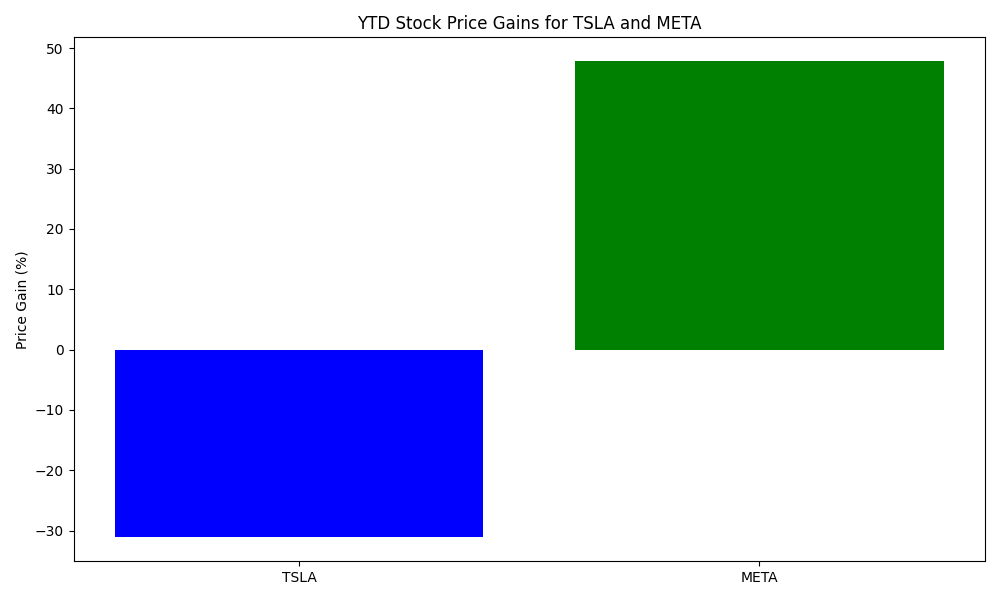

In [14]:
import os
from IPython.display import Image
print(temp_dir)

Image(os.path.join(temp_dir.name, "stock_gains.png"))

In [15]:
temp_dir.cleanup()
!rm -rf /content/autogen/OAI_CONFIG_LIST